## Assignment 7 - Ruben Molina

Let's make this part the import zone. We will use the sklearn library, with the iris dataset. So let's import both, and call the dataset.

In [2]:
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd

In [3]:
# let's load the iris dataset. Since it's kind of universal, is also stored in the Pandas Module, so I loaded from there.
iris = datasets.load_iris()

In [4]:
# And generate a dataframe, since its a nicer way of manipulating data than a numpy array
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)

In [5]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


#### 1. Describe the dataset

The dataset is made of 150 observations described by 4 variables: Sepal Length, Sepal Width, Petal Length and Petal Width, in centimeter dimension. Let's generate a descriptive statistics table for each of the variables.

In [6]:
descriptive = pd.DataFrame(columns = ['Mean', "Std", "Min", "25%", "50%", "75%", "Max"])

In [7]:
descriptive.loc["Sepal Length (cm)"] = (list(iris_df['sepal length (cm)'].describe())[1:])
descriptive.loc["Sepal Width (cm)"] = (list(iris_df['sepal width (cm)'].describe())[1:])
descriptive.loc["Petal Length (cm)"] = (list(iris_df['petal length (cm)'].describe())[1:])
descriptive.loc["Petal Width (cm)"] = (list(iris_df['petal width (cm)'].describe())[1:])

In [8]:
descriptive
#Here we can see a descriptive table of the 4 variables that creates the dataset. 

,Mean,Std,Min,25%,50%,75%,Max
Sepal Length (cm),5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
Sepal Width (cm),3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
Petal Length (cm),3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
Petal Width (cm),1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


#### 2) Using pyMC3, we want to infer the parameters of the following models:
   
#### a) The mean and standard deviation of the distribution of one feature chosen by you, that we assume as normally distributed.
#### b) The Petal Width as linear function of the other three features.

In [9]:
import pymc3 as pm

In [11]:
with pm.Model() as model_g:
    u = pm.Uniform('u', lower=0, upper=300)    #This is a distribution for the mean
    o = pm.HalfNormal('o', sd=10)     #This is the standard deviation
    y = pm.Normal('y', mu=u, sd=o, observed=iris_df['sepal length (cm)'].values) #And this is the y values
    trace_g = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [o, u]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4329.05draws/s]


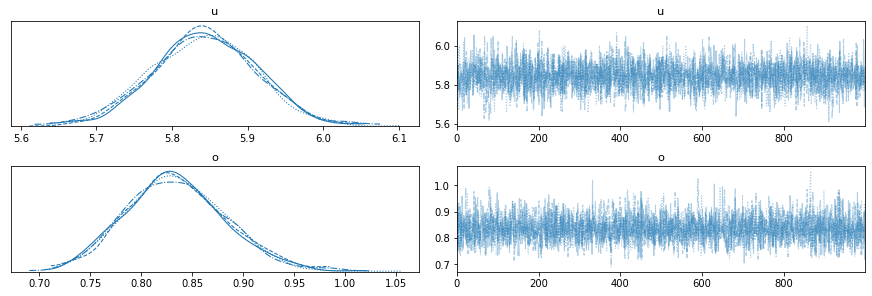

In [12]:
pm.traceplot(trace_g);

In [13]:
pm.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
u,5.843,0.068,5.712,5.965,0.001,0.001,3505.0,3505.0,3504.0,2643.0,1.0
o,0.835,0.049,0.747,0.929,0.001,0.001,3559.0,3537.0,3574.0,2513.0,1.0


We have estimated a mean of 5.844. The real value is 5.843, so we have predicted it extremely close. Let's check now the Petal Width as a linear function of the other three. Therefore we are going to do a linear regression.

In [14]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=3)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0]*iris_df["sepal length (cm)"] + beta[1]*iris_df["sepal width (cm)"] + \
    beta[2]*iris_df["petal length (cm)"]

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=iris_df["petal width (cm)"])
    
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = 23.578, ||grad|| = 121.78: 100%|██████████| 41/41 [00:00<00:00, 1992.45it/s]    


{'alpha': array(-0.24023624),
 'beta': array([-0.20726557,  0.22280905,  0.52407952]),
 'sigma_log__': array(-1.66404433),
 'sigma': array(0.18937155)}

What we obtain, is the next equation:

Petal Width = -0.24 + -0.207 * Sepal Length + 0.222 * Sepal Width + 0.524 * Petal Length

#### 3) Clusterize the plants according to its features and analyse the results of the clusters as indication of the type of plant.

In [15]:
from sklearn import cluster
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [16]:
iris = datasets.load_iris()
dataframe = pd.DataFrame(iris['data'], columns=iris['feature_names'])
dataframe

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [17]:
X = iris.data[:, :3]
y = iris.target

First let's do a visualization of the classes according to 3 features. 

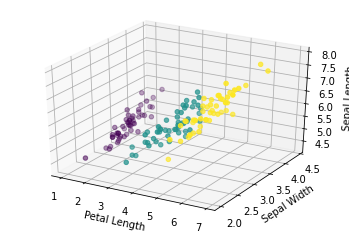

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,2], X[:,1], X[:,0], zdir='z', s=20, c=y, depthshade=True)
ax.set_xlabel('Petal Length')
ax.set_ylabel('Sepal Width')
ax.set_zlabel('Sepal Length')
plt.show()

In [19]:
km = KMeans(n_clusters = 3, n_jobs = 4, random_state=21)
# We ask for 3 clusters as there are three types of flowers.

km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=4, precompute_distances='auto',
       random_state=21, tol=0.0001, verbose=0)

In [20]:
# Let's identify the centers of the algorithm

centers = km.cluster_centers_
print(centers)

[[5.84655172 2.73275862 4.3637931 ]
 [5.006      3.428      1.462     ]
 [6.83571429 3.06428571 5.6547619 ]]


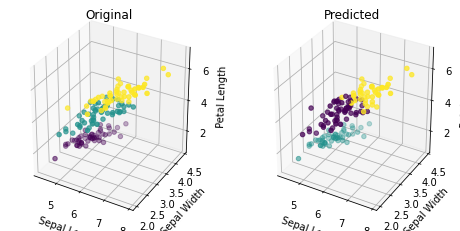

In [21]:
#this will tell us to which cluster does the data observations belong.
new_labels = km.labels_

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], zdir='z', s=20, c=y, depthshade=True)
ax.set_xlabel('Sepal Length')
ax.set_ylabel('Sepal Width')
ax.set_zlabel('Petal Length')
ax.set_title("Original")

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
ax.scatter(X[:,0], X[:,1], X[:,2], zdir='z', s=20, c=new_labels, depthshade=True)
ax.set_xlabel('Sepal Length')
ax.set_ylabel('Sepal Width')
ax.set_zlabel('Petal Length')
ax.set_title("Predicted")

plt.show()


#### 4) Use a random forest classification and express which is the importance of each feature to infer the type of plant.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Now we need to create a training and a test set.

In [23]:
y = pd.Categorical.from_codes(iris.target, iris.target_names)
X_train, X_test, y_train, y_test = train_test_split(dataframe, y, test_size=0.33, random_state=42)

In [24]:
print ("Length of train dataset is:", len(X_train))
print ("Length of test dataset is:", len(X_test))

Length of train dataset is: 100
Length of test dataset is: 50


In [25]:
features = dataframe.columns
features

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [26]:
# We need the categorical variables as factors

y_test_factor = pd.factorize(y_test)[0]
y_train_factor = pd.factorize(y_train)[0]


In [27]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)

In [28]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

We have generated the Random Forest Classifier. Let's apply it to the Test data

In [29]:
predicted = clf.predict(X_test)

In [30]:
pd.crosstab(y_test, predicted, rownames=['Actual Species'], colnames=['Predicted Species'])


Predicted Species,setosa,versicolor,virginica
Actual Species,,,
setosa,19,0,0
versicolor,0,15,0
virginica,0,1,15


In [31]:
#For checking the importance of each feature, let's see the importance scores.

list(zip(X_train, clf.feature_importances_))

[('sepal length (cm)', 0.0983732282540144),
 ('sepal width (cm)', 0.040953940122995136),
 ('petal length (cm)', 0.4093868247751606),
 ('petal width (cm)', 0.4512860068478299)]

As we can see, the main features for classify the plants, are the petal length and the petal width. This is as expected, because if we check the 3D plot of before, the sepal variables do not distinguish much the data, while we see difference in the clusters according to petal variable.

#### 5) Analyze the dependence (or independence) of each one of the features within the data set.

For doing this we will simply perform a plot of a correlation matrix, showing us the correlation between the variables in the iris dataset.

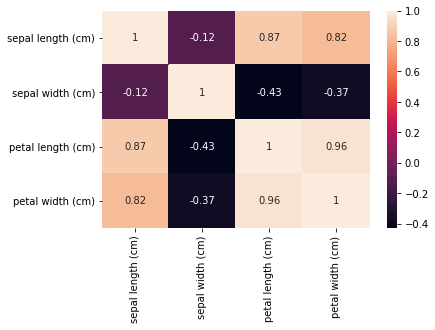

In [32]:
import seaborn as sns

corrMatrix = dataframe.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### 6) If we assign the following numerical values: Setosa=0, Versicolour=1, and Virginica=2 and we propose the following causal model:
    
#### Sepal Length -> Sepal Width -> Plant Type <- Petal Width <- Petal Length

#### a) Which relation of independence we should expect between Sepal Length and Petal Length? Check it.
#### b) And if we condition on Plant type?
#### c) And if we condition on Petal Width?

In [58]:
import scipy.stats as st

First of all, we need to convert the factor variable of the type, into a numeric variable.

In [35]:
names = y.rename_categories({'setosa': 0, 'versicolor': 1, 'virginica':2})

In [37]:
print (names)

[0, 0, 0, 0, 0, ..., 2, 2, 2, 2, 2]
Length: 150
Categories (3, int64): [0, 1, 2]


If we think about the relation of independence between Sepal Length and Petal Length and we take into account the diagram, we should not expect dependency between them if the plant type is not conditioned, since its a collider. If we condition for the Plant Type, we should see dependency between Sepal Length and Petal Length.

Let's create a matrix that represents the causal graph.

In [69]:
causal_graph = pd.DataFrame({"Sepal Length": [0,0,0,0,0], "Sepal Width":[1,0,0,0,0], "Plant Type":[0,1,0,1,0], "Petal Width":[0,0,0,0,1], "Petal Length":[0,0,0,0,0]})
causal_graph = causal_graph.rename(index={0:'Sepal Length',1:'Sepal Width', 2:"Plant Type", 3:"Petal Width", 4:"Petal Length"})
causal_graph

,Sepal Length,Sepal Width,Plant Type,Petal Width,Petal Length
Sepal Length,0,1,0,0,0
Sepal Width,0,0,1,0,0
Plant Type,0,0,0,0,0
Petal Width,0,0,1,0,0
Petal Length,0,0,0,1,0


Now lets generate the data matrix from the observations. We already have it, but is better to ensure that labels are the same, and everything is in place.

In [70]:
causal_data = pd.DataFrame({"Sepal Length": dataframe["sepal length (cm)"], 
                            "Sepal Width":dataframe["sepal width (cm)"], 
                            "Plant Type":names, 
                            "Petal Width":dataframe["petal width (cm)"], 
                            "Petal Length":dataframe["petal length (cm)"]})
causal_data.head()

,Sepal Length,Sepal Width,Plant Type,Petal Width,Petal Length
0,5.1,3.5,0,0.2,1.4
1,4.9,3.0,0,0.2,1.4
2,4.7,3.2,0,0.2,1.3
3,4.6,3.1,0,0.2,1.5
4,5.0,3.6,0,0.2,1.4
...,...,...,...,...,...
145,6.7,3.0,2,2.3,5.2
146,6.3,2.5,2,1.9,5.0
147,6.5,3.0,2,2.0,5.2
148,6.2,3.4,2,2.3,5.4


In [71]:
def obtain_basis(random_graph):
#Let's obtain first, which are the parents from each vertex.

    parents = dict()
    basis_set = dict()

    # Get the parents dictionary

    for element in random_graph.columns:
        for element2 in random_graph.index:
            parents[element] = list()

    for element in random_graph.columns:
        for element2 in random_graph.index:
            if random_graph.loc[element2, element] != 0:
                parents.setdefault(element,[]).append(str(element2))

    # For each non-adjacent pair, check parents.

    for element in random_graph.columns:
        for element2 in random_graph.index:
            if random_graph.loc[element2, element] == 0 and random_graph.loc[element, element2] == 0:
                if element > element2:
                    elements = (element, element2)
                else:
                    elements = (element2, element)

                if element != element2:
                    basis_set[elements] = set(parents[elements[0]] + parents[elements[1]])   
    
    return basis_set

def print_d_separation(basis_set):
    print ("The d-separation statement for the basis set is the next one:\n")
    for key in basis_set.keys():
            print (key[0],"||", key[1],"|", (",").join(basis_set[key]))
    return None

In [72]:
basis_set = obtain_basis(causal_graph)
print_d_separation(basis_set)

The d-separation statement for the basis set is the next one:

Sepal Length || Plant Type | Sepal Width,Petal Width
Sepal Length || Petal Width | Petal Length
Sepal Length || Petal Length | 
Sepal Width || Petal Width | Sepal Length,Petal Length
Sepal Width || Petal Length | Sepal Length
Plant Type || Petal Length | Sepal Width,Petal Width


### Note: From that points below, exists some bug on the code that give us a result not expected. Therefore in the end is appended a summary explaining what we expect, and what we obtained and why is wrong. 

In [84]:
# First let's generate a function that give us data.

def check_independence(basis_set, data, threshold):
    for key in basis_set.keys():
        r = st.pearsonr(data[key[0]], data[key[1]])[0]
        tr = (r*(n-2)**1/2) * ((1-r**2)**1/2)
        pval = st.t.sf(np.abs(tr), n-1)*2  # two-sided pvalue = Prob(abs(t)>tt)
        print ("Independence between", key[0],"and" , key[1], ":" , pval <= threshold)
    

In [104]:
# Now we have to compute the pearson coefficient against each one of the pairs.

n=100
num_var = len(causal_graph.columns)

basis_set = obtain_basis(causal_graph)

check_independence(basis_set, causal_data, 0.05)


Independence between Sepal Length and Plant Type : True
Independence between Sepal Length and Petal Width : True
Independence between Sepal Length and Petal Length : True
Independence between Sepal Width and Petal Width : True
Independence between Sepal Width and Petal Length : True
Independence between Plant Type and Petal Length : True


### Conditioning for Plant Type

Although our data has a collider in the Plant Type variable, we are not controlling for it, therefore we are observing independence on all the combinations of variables of the basis set, as expected.


In [105]:
# If we control on plant type, that means that we are only taking observations with the same plant type. Let's grab them.

# SETOSA PLANTS
setosa_data = causal_data[causal_data['Plant Type'] == 0]
check_independence(basis_set, setosa_data, 0.05)


Independence between Sepal Length and Plant Type : False
Independence between Sepal Length and Petal Width : True
Independence between Sepal Length and Petal Length : True
Independence between Sepal Width and Petal Width : True
Independence between Sepal Width and Petal Length : True
Independence between Plant Type and Petal Length : False


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [78]:
#VERSICOLOR PLANTS
setosa_data = causal_data[causal_data['Plant Type'] == 1]
check_independence(basis_set, setosa_data, 0.05)

Sepal Length  and  Plant Type False
Sepal Length  and  Petal Width True
Sepal Length  and  Petal Length True
Sepal Width  and  Petal Width True
Sepal Width  and  Petal Length True
Plant Type  and  Petal Length False


In [79]:
# VIRGNINICA PLANTS
setosa_data = causal_data[causal_data['Plant Type'] == 2]
check_independence(basis_set, setosa_data, 0.05)

Sepal Length  and  Plant Type False
Sepal Length  and  Petal Width True
Sepal Length  and  Petal Length True
Sepal Width  and  Petal Width True
Sepal Width  and  Petal Length True
Plant Type  and  Petal Length False


After checking the different variable values for plant type, we can see that we have dependency.

### Conditioning for Petal Width

Now let's distribute into bins the Petal Width parameter, and check the dependency inside the bins.

In [97]:
categories_petal = pd.cut(causal_data["Petal Width"], 5, labels=False)

Now we have 10 categories on the Petal Width variable, which would serve us to take only one bin, and then kind of condition for the variable, let's see now the dependency.

In [103]:
petal_categ_data = pd.DataFrame({"Sepal Length": dataframe["sepal length (cm)"], 
                            "Sepal Width":dataframe["sepal width (cm)"], 
                            "Plant Type":names, 
                            "Petal Width":categories_petal, 
                            "Petal Length":dataframe["petal length (cm)"]})
petal_categ_data.head()

,Sepal Length,Sepal Width,Plant Type,Petal Width,Petal Length
0,5.1,3.5,0,0,1.4
1,4.9,3.0,0,0,1.4
2,4.7,3.2,0,0,1.3
3,4.6,3.1,0,0,1.5
4,5.0,3.6,0,0,1.4


Nice, let's take only one category of Petal Width

In [102]:
petal_5 = petal_categ_data[petal_categ_data['Petal Width'] == 3]
check_independence(basis_set, petal_5, 0.05)

Independence between Sepal Length and Plant Type : True
Independence between Sepal Length and Petal Width : False
Independence between Sepal Length and Petal Length : True
Independence between Sepal Width and Petal Width : False
Independence between Sepal Width and Petal Length : True
Independence between Plant Type and Petal Length : True


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


### Let's summarize a bit.

When we do not condition for anything, all the variables of the basis set are independent within them. 
This is as expected.

When we condition for the plant type, which is a collider, we should see that all the combinations of variables in which one of them is "Petal" and the other "Sepal" should be dependent within them. This is not what we obtained here, so the code must be wrong in some part.

Finally, when we condition for the Petal Width, we should found that all the variation in the plant type comes from the Sepal Width, since we are losing the effect of Petal Length by conditioning the Petal Width variable. As before, this is not consistent with the results of our code.
